In [1]:
# Importing libraries and switching to the right directory
import pandas as pd 
import numpy as np
import os  
from openpyxl import load_workbook
from google.colab import drive
from tqdm.notebook import tqdm

# mounting ggdrive 
drive.mount('/content/drive')

# custom data paths - each person should add their own file to the ggdrive 'Data Analytics - Group Final Projects' folder if they want to use ggcolab :D
paths = {'theau': '/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/SRS',
         'victor': '/content/drive/MyDrive/Columbia 1st Semester/Sports Analytics/Sports Analytics - Project/SRS',
         'max': '/content/drive/MyDrive/1_FALL 2022/Sports Analytics/Sports Analytics - Project/SRS'
         }

# setting os chdir
runner = input("Who's running the notebook? (type lowercase) ")
os.chdir(paths[runner])
print("Drive mounted for %s!" %runner)

Mounted at /content/drive
Who's running the notebook? (type lowercase) theau
Drive mounted for theau!


## Importing fitted SRS tables

In [2]:
def import_SWP_year(year, regressed = True):
  if regressed == True :
    folder_path =  'fitted_srs_regressed/'
  else: 
    folder_path = 'fitted_srs/'
  if year != 2022:
    ranking_sheet = pd.read_excel(folder_path + 'atp_srs_rating_%i_fitted.xlsx' % year,
                                  sheet_name = 'SRS',
                                  usecols='X:AC',
                                  skiprows=14
                                  )
  else: 
    ranking_sheet = pd.read_excel(folder_path + 'atp_srs_rating_%i_fitted.xlsx' % year,
                                sheet_name = 'SRS',
                                usecols='X:AC',
                                skiprows=15
                                )
  return ranking_sheet
for k in range(2001,2023):
  SWP_test = import_SWP_year(k)
  print(k, ': ' , SWP_test.columns[:3].tolist())

2001 :  ['SRS (30,6)', 'RMSE', 0.0392519289764087]
2002 :  ['SRS (101,6)', 'RMSE', 3.7253752181620326e-07]
2003 :  ['SRS (520,6)', 'RMSE', 0.12414225789384838]
2004 :  ['SRS (510,6)', 'RMSE', 0.08795137303171599]
2005 :  ['SRS (496,6)', 'RMSE', 0.099683990533945]
2006 :  ['SRS (529,6)', 'RMSE', 0.10644467885142031]
2007 :  ['SRS (500,6)', 'RMSE', 0.1130870302360889]
2008 :  ['SRS (494,6)', 'RMSE', 0.12908878577879573]
2009 :  ['SRS (469,6)', 'RMSE', 0.12177335847029101]
2010 :  ['SRS (477,6)', 'RMSE', 0.12809568317289122]
2011 :  ['SRS (464,6)', 'RMSE', 0.12033874513884586]
2012 :  ['SRS (464,6)', 'RMSE', 0.1276814281367477]
2013 :  ['SRS (461,6)', 'RMSE', 0.14564224120417302]
2014 :  ['SRS (430,6)', 'RMSE', 0.16386044520878196]
2015 :  ['SRS (434,6)', 'RMSE', 0.09792269652242093]
2016 :  ['SRS (435,6)', 'RMSE', 0.13940947308314697]
2017 :  ['SRS (443,6)', 'RMSE', 0.13249313968019533]
2018 :  ['SRS (428,6)', 'RMSE', 0.12176971560330165]
2019 :  ['SRS (368,6)', 'RMSE', 0.147603485501088

In [3]:
def preprocess_swp_df(SWP_raw):
    average_swp = SWP_raw['RMSE'].iloc[0]
    ratings_df = SWP_raw.copy()
    ratings_df.columns = ratings_df.iloc[3].tolist()
    ratings_df = ratings_df.iloc[4:,:]
    server_ratings_df = ratings_df.iloc[:,:2].set_index('server').dropna()
    receiver_ratings_df = ratings_df.iloc[:,3:5].set_index('receiver').dropna()
    return average_swp, server_ratings_df, receiver_ratings_df

In [4]:
SWP_2012 = import_SWP_year(2012)
swp_2012, server_ratings_2012, receiver_ratings_2012 = preprocess_swp_df(SWP_2012)

In [5]:
def compute_A_serves_B_SWP(average_swp, server_ratings, receiver_ratings, A, B):
  # computes SWP for A against B
    return float(average_swp + server_ratings.loc[A] - receiver_ratings.loc[B])

In [6]:
compute_A_serves_B_SWP(swp_2012, server_ratings_2012, receiver_ratings_2012, 'Rafael Nadal', 'Novak Djokovic')

0.6598644079367426

In [7]:
compute_A_serves_B_SWP(swp_2012, server_ratings_2012, receiver_ratings_2012, 'Novak Djokovic', 'Rafael Nadal')

0.5742596163042045

## Probability to Win a Match

Proba of winning a point

**Inputs** 

- proba of winning a point if A serving : ps

- proba of winning a point if A receiving : pr


In [8]:
A_win=1
A_lose=0
# Service game
def proba_game_service(ps):
  Deuce=ps**2/(1-2*ps*(1-ps))
  A_adv=ps*A_win+Deuce*(1-ps)
  B_adv=ps*Deuce+(1-ps)*A_lose
  pt_40_15=ps*A_win+(1-ps)*A_adv
  pt_30_30=ps*A_adv+(1-ps)*B_adv
  pt_15_40=ps*B_adv+(1-ps)*A_lose
  pt_40_0=ps*A_win+(1-ps)*pt_40_15
  pt_30_15=ps*pt_40_15+(1-ps)*pt_30_30
  pt_15_30=ps*pt_30_30+(1-ps)*pt_15_40
  pt_0_40=ps*pt_15_40+(1-ps)*A_lose
  pt_30_0=ps*pt_40_0+(1-ps)*pt_30_15
  pt_15_15=ps*pt_30_15+(1-ps)*pt_15_30
  pt_0_30=ps*pt_15_30+(1-ps)*pt_0_40
  pt_15_0=ps*pt_30_0+(1-ps)*pt_15_15
  pt_0_15=ps*pt_15_15+(1-ps)*pt_0_30
  pt_0_0=ps*pt_15_0+(1-ps)*pt_0_15
  return(pt_0_0)

# Return game
def proba_game_receiving(pr):
  Deuce=pr**2/(1-2*pr*(1-pr))
  A_adv=pr*A_win+Deuce*(1-pr)
  B_adv=pr*Deuce+(1-pr)*A_lose
  pt_40_15=pr*A_win+(1-pr)*A_adv
  pt_30_30=pr*A_adv+(1-pr)*B_adv
  pt_15_40=pr*B_adv+(1-pr)*A_lose
  pt_40_0=pr*A_win+(1-pr)*pt_40_15
  pt_30_15=pr*pt_40_15+(1-pr)*pt_30_30
  pt_15_30=pr*pt_30_30+(1-pr)*pt_15_40
  pt_0_40=pr*pt_15_40+(1-pr)*A_lose
  pt_30_0=pr*pt_40_0+(1-pr)*pt_30_15
  pt_15_15=pr*pt_30_15+(1-pr)*pt_15_30
  pt_0_30=pr*pt_15_30+(1-pr)*pt_0_40
  pt_15_0=pr*pt_30_0+(1-pr)*pt_15_15
  pt_0_15=pr*pt_15_15+(1-pr)*pt_0_30
  pt_0_0=pr*pt_15_0+(1-pr)*pt_0_15
  return(pt_0_0)

In [9]:
def proba_tie_break(ps,pr):

  #service
  pt_6_6=(ps*pr+ps*pr*(ps*(1-pr)+pr*(1-ps)))/(1-(pr*(1-ps)+ps*(1-pr))**2)
  pt_6_5=ps*A_win+(1-ps)*pt_6_6
  pt_5_6=ps*pt_6_6+(1-ps)*A_lose

  #return
  pt_6_4=pr*A_win+(1-pr)*pt_6_5
  pt_5_5=pr*pt_6_5+(1-pr)*pt_5_6
  pt_4_6=pr*pt_5_6+(1-pr)*A_lose

  pt_6_3=pr*A_win+(1-pr)*pt_6_4
  pt_5_4=pr*pt_6_4+(1-pr)*pt_5_5
  pt_4_5=pr*pt_5_5+(1-pr)*pt_4_6
  pt_3_6=pr*pt_4_6+(1-pr)*A_lose

  #service
  pt_6_2=ps*A_win+(1-ps)*pt_6_3
  pt_5_3=ps*pt_6_3+(1-ps)*pt_5_4
  pt_4_4=ps*pt_5_4+(1-ps)*pt_4_5
  pt_3_5=ps*pt_4_5+(1-ps)*pt_3_6
  pt_2_6=ps*pt_3_6+(1-ps)*A_lose

  pt_6_1=ps*A_win+(1-ps)*pt_6_2
  pt_5_2=ps*pt_6_2+(1-ps)*pt_5_3
  pt_4_3=ps*pt_5_3+(1-ps)*pt_4_4
  pt_3_4=ps*pt_4_4+(1-ps)*pt_3_5
  pt_2_5=ps*pt_3_5+(1-ps)*pt_2_6
  pt_1_6=ps*pt_2_6+(1-ps)*A_lose

  #return
  pt_6_0=pr*A_win+(1-pr)*pt_6_1
  pt_5_1=pr*pt_6_1+(1-pr)*pt_5_2
  pt_4_2=pr*pt_5_2+(1-pr)*pt_4_3
  pt_3_3=pr*pt_4_3+(1-pr)*pt_3_4
  pt_2_4=pr*pt_3_4+(1-pr)*pt_2_5
  pt_1_5=pr*pt_2_5+(1-pr)*pt_1_6
  pt_0_6=pr*pt_1_6+(1-pr)*A_lose

  pt_5_0=pr*pt_6_0+(1-pr)*pt_5_1
  pt_4_1=pr*pt_5_1+(1-pr)*pt_4_2
  pt_3_2=pr*pt_4_2+(1-pr)*pt_3_3
  pt_2_3=pr*pt_3_3+(1-pr)*pt_2_4
  pt_1_4=pr*pt_2_4+(1-pr)*pt_1_5
  pt_0_5=pr*pt_1_5+(1-pr)*pt_0_6

  #service
  pt_4_0=ps*pt_5_0+(1-ps)*pt_4_1
  pt_3_1=ps*pt_4_1+(1-ps)*pt_3_2
  pt_2_2=ps*pt_3_2+(1-ps)*pt_2_3
  pt_1_3=ps*pt_2_3+(1-ps)*pt_1_4
  pt_0_4=ps*pt_1_4+(1-ps)*pt_0_5

  pt_3_0=ps*pt_4_0+(1-ps)*pt_3_1
  pt_2_1=ps*pt_3_1+(1-ps)*pt_2_2
  pt_1_2=ps*pt_2_2+(1-ps)*pt_1_3
  pt_0_3=ps*pt_1_3+(1-ps)*pt_0_4

  #return
  pt_2_0=pr*pt_3_0+(1-pr)*pt_2_1
  pt_1_1=pr*pt_2_1+(1-pr)*pt_1_2
  pt_0_2=pr*pt_1_2+(1-pr)*pt_0_3

  pt_1_0=pr*pt_2_0+(1-pr)*pt_1_1
  pt_0_1=pr*pt_1_1+(1-pr)*pt_0_2

  #service
  pt_0_0=ps*pt_1_0+(1-ps)*pt_0_1
  return(pt_0_0)

In [10]:
proba_tie_break(0.6,0.45)

0.579566798641837

In [11]:
def proba_set(pgs,pgr,ptb):
  #service
  pt_6_5=pgs*A_win+(1-pgs)*ptb
  pt_5_6=pgs*ptb+(1-pgs)*A_lose

  #return
  pt_5_5=pgr*pt_6_5+(1-pgr)*pt_5_6
  pt_5_4=pgr*A_win+(1-pgr)*pt_5_5
  pt_4_5=pgr*pt_5_5+(1-pgr)*A_lose

  #service
  pt_5_3=pgs*A_win+(1-pgs)*pt_5_4
  pt_4_4=pgs*pt_5_4+(1-pgs)*pt_4_5
  pt_3_5=pgs*pt_4_5+(1-pgs)*A_lose

  #return
  pt_5_2=pgr*A_win+(1-pgr)*pt_5_3
  pt_4_3=pgr*pt_5_3+(1-pgr)*pt_4_4
  pt_3_4=pgr*pt_4_4+(1-pgr)*pt_3_5
  pt_2_5=pgr*pt_3_5+(1-pgr)*A_lose

  #service
  pt_5_1=pgs*A_win+(1-pgs)*pt_5_2
  pt_4_2=pgs*pt_5_2+(1-pgs)*pt_4_3
  pt_3_3=pgs*pt_4_3+(1-pgs)*pt_3_4
  pt_2_4=pgs*pt_3_4+(1-pgs)*pt_2_5
  pt_1_5=pgs*pt_2_5+(1-pgs)*A_lose

  #return
  pt_5_0=pgr*A_win+(1-pgr)*pt_5_1
  pt_4_1=pgr*pt_5_1+(1-pgr)*pt_4_2
  pt_3_2=pgr*pt_4_2+(1-pgr)*pt_3_3
  pt_2_3=pgr*pt_3_3+(1-pgr)*pt_2_4
  pt_1_4=pgr*pt_2_4+(1-pgr)*pt_1_5
  pt_0_5=pgr*pt_1_5+(1-pgr)*A_lose

  #service
  pt_4_0=pgs*pt_5_0+(1-pgs)*pt_4_1
  pt_3_1=pgs*pt_4_1+(1-pgs)*pt_3_2
  pt_2_2=pgs*pt_3_2+(1-pgs)*pt_2_3
  pt_1_3=pgs*pt_2_3+(1-pgs)*pt_1_4
  pt_0_4=pgs*pt_1_4+(1-pgs)*pt_0_5

  #return
  pt_3_0=pgr*pt_4_0+(1-pgr)*pt_3_1
  pt_2_1=pgr*pt_3_1+(1-pgr)*pt_2_2
  pt_1_2=pgr*pt_2_2+(1-pgr)*pt_1_3
  pt_0_3=pgr*pt_1_3+(1-pgr)*pt_0_4

  #service
  pt_2_0=pgs*pt_3_0+(1-pgs)*pt_2_1
  pt_1_1=pgs*pt_2_1+(1-pgs)*pt_1_2
  pt_0_2=pgs*pt_1_2+(1-pgs)*pt_0_3

  #return
  pt_1_0=pgr*pt_2_0+(1-pgr)*pt_1_1
  pt_0_1=pgr*pt_1_1+(1-pgr)*pt_0_2

  #service
  pt_0_0=pgs*pt_1_0+(1-pgs)*pt_0_1
  return(pt_0_0)

In [12]:
print(proba_set(0.7357292307692308,0.3768514975247526,0.579566798641837))

0.6694778245600762


In [13]:
# 3 sets match victory
def proba_match(pgset):
  set_1_1=pgset*A_win+(1-pgset)*A_lose
  set_1_0=pgset*A_win+(1-pgset)*set_1_1
  set_0_1=pgset*set_1_1+(1-pgset)*A_lose
  set_0_0=pgset*set_1_0+(1-pgset)*set_0_1
  return(set_0_0)

In [14]:
# Sum up code with final function
# Input : ps and pr
# Output : proba of winning the match
def proba_winning_match(ps,pr):
  #Game
  proba_winning_serve_game=proba_game_service(ps)
  proba_winning_receive_game=proba_game_receiving(pr)
  #Tie break
  proba_winning_tie_break=proba_tie_break(ps,pr)
  #Set
  proba_winning_set=proba_set(proba_winning_serve_game,proba_winning_receive_game,proba_winning_tie_break)
  #Match
  proba_winning_match=proba_match(proba_winning_set)
  return proba_winning_match

In [15]:
# Testing
proba_winning_match(0.66,0.40)

0.7749740004740365

## SRS Model Results

Inputs

proba of winning a point if A serving : ps

proba of winning a point if A receiving : pr

In [16]:
import random

In [17]:
def proba_win(player_1, player_2, year):
  """ 
  Returns win if player_1 wins according to simulation and lose otherwise 
  """
  SWP_year = import_SWP_year(year)
  swp_year_avg, server_ratings_year, receiver_ratings_year = preprocess_swp_df(SWP_year)
  try:
    p_win_pt_1_s_2 = compute_A_serves_B_SWP(swp_year_avg, 
                                        server_ratings_year,
                                        receiver_ratings_year, 
                                        player_1,
                                        player_2)
    
    p_win_pt_1_r_2 = 1 - compute_A_serves_B_SWP(swp_year_avg, 
                                            server_ratings_year,
                                            receiver_ratings_year, 
                                            player_2,
                                            player_1)
    prob_win_1_2 = proba_winning_match(p_win_pt_1_s_2,
                                      p_win_pt_1_r_2)
  except:
    prob_win_1_2 = np.nan
  
  return prob_win_1_2

def simulate_match_SRS(player_1, player_2, year):
  prob_win_1_2 = proba_win(player_1, player_2, year)
  # we generate a random number between 0 and 1 (uniform distribution)
  random_number = random.uniform(0, 1)
  # if it is inferior to the win probability, then we consider that player_1 wins the match 
  if random_number < prob_win_1_2:
    return 1
  else:
    return 0

def simulate_match_SRS_short(proba):
  prob_win_1_2 = proba
  # we generate a random number between 0 and 1 (uniform distribution)
  random_number = random.uniform(0, 1)
  # if it is inferior to the win probability, then we consider that player_1 wins the match 
  if random_number < prob_win_1_2:
    return 1
  else:
    return 0

In [18]:
player_1, player_2 = 'Rafael Nadal', 'Richard Gasquet'
year = 2021
for i in range(10):
  bool_result = bool(simulate_match_SRS(player_1, player_2, year))
  print(player_1, bool_result*'wins' + (1-bool_result)*'loses', 'against %s' % player_2) 

Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet
Rafael Nadal loses against Richard Gasquet


In [ ]:
year = 2012
pd.read_csv('/content/drive/MyDrive/1_FALL 2022/Sports Analytics/Sports Analytics - Project/Data/atp_matches_scores/atp_matches_{}.csv'.format(str(year)))

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2012-339,Brisbane,Hard,32,A,20120101,1,104918,1.0,NaN,...,41.0,29.0,15.0,14.0,4.0,9.0,4.0,7380.0,91.0,598.0
1,2012-339,Brisbane,Hard,32,A,20120101,2,104180,NaN,NaN,...,67.0,54.0,20.0,16.0,1.0,2.0,54.0,893.0,85.0,630.0
2,2012-339,Brisbane,Hard,32,A,20120101,3,104571,NaN,NaN,...,48.0,36.0,17.0,11.0,2.0,4.0,44.0,940.0,79.0,658.0
3,2012-339,Brisbane,Hard,32,A,20120101,4,105453,5.0,NaN,...,49.0,27.0,23.0,13.0,9.0,14.0,25.0,1430.0,81.0,652.0
4,2012-339,Brisbane,Hard,32,A,20120101,5,104797,NaN,NaN,...,38.0,28.0,11.0,9.0,0.0,0.0,73.0,685.0,23.0,1630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,2012-605,Tour Finals,Hard,8,F,20121105,515,104925,1.0,NaN,...,57.0,35.0,19.0,12.0,3.0,7.0,1.0,11420.0,2.0,9465.0
3005,2012-M-DC-2012-WG-M-ESP-CZE-01,Davis Cup WG F: ESP vs CZE,Hard,4,D,20121116,1,103970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,6430.0,37.0,1060.0
3006,2012-M-DC-2012-WG-M-ESP-CZE-01,Davis Cup WG F: ESP vs CZE,Hard,4,D,20121116,2,104607,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4605.0,11.0,2515.0
3007,2012-M-DC-2012-WG-M-ESP-CZE-01,Davis Cup WG F: ESP vs CZE,Hard,4,D,20121116,4,103970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,6430.0,6.0,4605.0


In [19]:
from sklearn.metrics import brier_score_loss

In [22]:
def makePredictions(year: int): 
  """
  Function that takes as input the year to make predictions and the dataframe of ratings 
  Compares two models: 
  - One using SRS rankings
  """
  SWP_year = import_SWP_year(year-1)
  swp_year_avg, server_ratings_year, receiver_ratings_year = preprocess_swp_df(SWP_year)

  # Create dataframe that will store the results 
  df_results = pd.DataFrame(index=['srs_model'], columns=['total_matches_predicted','unavailable_srs_matches','predicted_matches_percentage','correct_predictions','accuracy','brier_score'])
  # Reading table 
  table_name = '/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/Data/atp_matches_scores/atp_matches_{}.csv'.format(str(year))
  #table_name = '/content/drive/MyDrive/1_FALL 2022/Sports Analytics/Sports Analytics - Project/Data/atp_matches_scores/atp_matches_{}.csv'.format(str(year))
  df_year = pd.read_csv(table_name)
  df_year.sort_values('tourney_date', ascending=True, inplace=True, ignore_index=True) # sorting matches in chronological order 
  # Creating additional features
  total_matches_played = int(df_year.shape[0]) 
  list_expected_output = [1]*total_matches_played  # Binary output (0 or 1 for loss or win) : we always focus on the winner of the match so the output is 1 each time 
  srs_predicted_output = [] # Fill this list with binary outcomes (win or loss)
  srs_predicted_proba = [] # Fill this list with expected win probability 
  matches_possible_srs = []
  unavailable_matches = {'winner': [],
                         'loser': []}
  # Iterate through each match of that year 
  for k in tqdm(range(total_matches_played)):
    # Identify winner and loser id, as well as their index in the ratings df 
    w_name, l_name = df_year.loc[k,'winner_name'], df_year.loc[k,'loser_name']
    # w_index = df_ratings[df_ratings['player_id']==w_id].index[0]
    # l_index = df_ratings[df_ratings['player_id']==l_id].index[0]
    # Extract their current elos and rankings 
    # w_elo, w_ranking = df_ratings.loc[w_index,'elo'], df_year.loc[k,'winner_rank']
    # l_elo, l_ranking = df_ratings.loc[l_index,'elo'], df_year.loc[k,'loser_rank']
    # Compute expected_proba for the winner to actually win the match 
    try: 
      p_win_pt_1_s_2 = compute_A_serves_B_SWP(swp_year_avg, 
                                        server_ratings_year,
                                        receiver_ratings_year, 
                                        w_name,
                                        l_name)
    
      p_win_pt_1_r_2 = 1 - compute_A_serves_B_SWP(swp_year_avg, 
                                              server_ratings_year,
                                              receiver_ratings_year, 
                                              l_name,
                                              w_name)
      expected_proba = proba_winning_match(p_win_pt_1_s_2,
                                           p_win_pt_1_r_2)
      # Fill the lists of results 
      if expected_proba > 0.5:
        if expected_proba > 1:
          # print(expected_proba)
          expected_proba = 0.9999
          # print(p_win_pt_1_s_2, p_win_pt_1_r_2)
          # print(w_name, l_name, expected_proba)
        srs_predicted_output.append(1)
      else:
        srs_predicted_output.append(0)
      matches_possible_srs.append(k)
      srs_predicted_proba.append(expected_proba)

    except: 
      unavailable_matches['winner'].append(w_name)
      unavailable_matches['loser'].append(l_name)
      pass
  # Compute brier score
  # print([k for k in srs_predicted_proba if k > 1])
  try : brier_score = brier_score_loss([list_expected_output[i] for i in matches_possible_srs], srs_predicted_proba)
  except : brier_score = np.nan
  # Fill final dataframe 
  df_results.loc['srs_model','total_matches_predicted'] = len(matches_possible_srs)
  df_results.loc['srs_model','unavailable_srs_matches'] = len(unavailable_matches['winner'])
  df_results.loc['srs_model','predicted_matches_percentage'] = '%i %%' %int((len(matches_possible_srs) / (len(matches_possible_srs) + len(unavailable_matches['winner'])))*100)
  df_results.loc['srs_model','correct_predictions'] = sum(srs_predicted_output)
  df_results.loc['srs_model','accuracy'] = round(sum(srs_predicted_output) / len(matches_possible_srs),3) 
  df_results.loc['srs_model','brier_score'] = round(brier_score,3)
  return df_results, pd.DataFrame(unavailable_matches)

In [23]:
results = {}
unavailable_matches = {}
for year in range(2002, 2023):
  print(year)
  results[year], unavailable_matches[year] = makePredictions(year)

2002


  0%|          | 0/3213 [00:00<?, ?it/s]

2003


  0%|          | 0/3218 [00:00<?, ?it/s]

2004


  0%|          | 0/3288 [00:00<?, ?it/s]

2005


  0%|          | 0/3264 [00:00<?, ?it/s]

2006


  0%|          | 0/3267 [00:00<?, ?it/s]

2007


  0%|          | 0/3192 [00:00<?, ?it/s]

2008


  0%|          | 0/3123 [00:00<?, ?it/s]

2009


  0%|          | 0/3085 [00:00<?, ?it/s]

2010


  0%|          | 0/3030 [00:00<?, ?it/s]

2011


  0%|          | 0/3015 [00:00<?, ?it/s]

2012


  0%|          | 0/3009 [00:00<?, ?it/s]

2013


  0%|          | 0/2944 [00:00<?, ?it/s]

2014


  0%|          | 0/2901 [00:00<?, ?it/s]

2015


  0%|          | 0/2943 [00:00<?, ?it/s]

2016


  0%|          | 0/2941 [00:00<?, ?it/s]

2017


  0%|          | 0/2911 [00:00<?, ?it/s]

2018


  0%|          | 0/2897 [00:00<?, ?it/s]

2019


  0%|          | 0/2806 [00:00<?, ?it/s]

2020


  0%|          | 0/1462 [00:00<?, ?it/s]

2021


  0%|          | 0/2733 [00:00<?, ?it/s]

2022


  0%|          | 0/2284 [00:00<?, ?it/s]

In [24]:
srs_results_df = pd.concat([results[year] for year in results.keys()], 
                           axis = 0)
srs_results_df.index = results.keys()
srs_results_df['proba Rafael Nadal - Richard Gasquet'] = [proba_win('Rafael Nadal', 'Richard Gasquet', year) for year in range(2002, 2023)]
srs_results_df['proba Richard Gasquet - Rafael Nadal'] = [proba_win('Richard Gasquet', 'Rafael Nadal', year) for year in range(2002, 2023)]

In [25]:
srs_results_df

,total_matches_predicted,unavailable_srs_matches,predicted_matches_percentage,correct_predictions,accuracy,brier_score,proba Rafael Nadal - Richard Gasquet,proba Richard Gasquet - Rafael Nadal
2002,161,3052,5 %,82,0.509,0.367,NaN,NaN
2003,705,2513,21 %,339,0.481,0.392,0.416724,0.583276
2004,2783,505,84 %,1419,0.51,0.281,0.852546,0.147454
2005,2946,318,90 %,1524,0.517,0.262,0.446210,0.553790
2006,2852,415,87 %,1441,0.505,0.274,0.322682,0.677318
2007,2861,331,89 %,1442,0.504,0.269,0.487301,0.512699
2008,2831,292,90 %,1483,0.524,0.272,0.507719,0.492281
2009,2799,286,90 %,1492,0.533,0.271,0.432208,0.567792
2010,2665,365,87 %,1359,0.51,0.273,0.077665,0.922335
2011,2774,241,92 %,1441,0.519,NaN,0.298817,0.701183


In [26]:
srs_results_df.to_csv('/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/Data/results/srs_results.csv')

In [ ]:
unavailable_matches[2019]

,winner,loser
0,Grigor Dimitrov,Janko Tipsarevic
1,Denis Kudla,Marc Polmans
2,Robin Haase,Jiri Lehecka
3,Philipp Kohlschreiber,David Szintai
4,Alexei Popyrin,Nerman Fatic
...,...,...
142,Ugo Humbert,Jannik Sinner
143,Jannik Sinner,Mikael Ymer
144,Miomir Kecmanovic,Alejandro Davidovich Fokina
145,Mikhail Kukushkin,Botic Van De Zandschulp


In [ ]:
# table_name = '/content/drive/MyDrive/1_FALL 2022/Sports Analytics/Sports Analytics - Project/Data/atp_matches_scores/atp_matches_{}.csv'.format(str(2021))
# df_year = pd.read_csv(table_name)
# df_year.sort_values('tourney_date', ascending=True, inplace=True, ignore_index=True)
# df_year

## Monte Carlo Simulations

In [ ]:
# Number of Nadal - Gasquet confrontations each year
# Source : ATP Tour website (https://www.atptour.com/en/players/atp-head-2-head/rafael-nadal-vs-richard-gasquet/N409/G628)
nadal_gasquet_matches = {2004:1, 2005:2, 2006:0, 2007:1, 2008:2, 2009:1, 2010:0, 2011:3, 2012:0, 2013:2, 2014:1, 2015:1, 2016:0, 2017:1, 2018:1, 2019:0, 2020:0, 2021:1, 2022:1}

def getLongestStreak(match_outcomes: list) -> int:
  """
  Function that outputs the longest streak of victories from a given a binary list of match outcomes (=longest subset of 1)
  """
  current_seq_len = 0 
  max_seq_len = 0 
  for outcome in match_outcomes:
    if outcome == 1:
      current_seq_len += 1 
      if current_seq_len > max_seq_len:
        max_seq_len = current_seq_len 
    else:
      current_seq_len = 0 
  return max_seq_len 

In [ ]:
def runMonteCarloSimulation(player_1: str, player_2: str, p1_v_p2_matches: dict, nb_simulations: int, srs_results_df: pd.DataFrame):
  """
  Function that runs Monte Carlo simulation for the 18 matches between Nadal and Gasquet 
  The objective is to see how many times a streak of 18 wins appear for Nadal 
  For each match, the probabilities of winning are computed from the ELOs of both players at the time of the match 
  """ 
  list_simulations = []
  list_longest_streaks = []
  for n in tqdm(range(nb_simulations)):
    simulation = []
    for year in p1_v_p2_matches.keys():
      # If there was at least one match during this year we perform a simulation
      if p1_v_p2_matches[year] > 0:
        for match in range(p1_v_p2_matches[year]):
          try: 
            proba_win_1_v_2 = srs_results_df.loc[year]['proba %s - %s' %(player_1, player_2)]
            simulation.append(simulate_match_SRS_short(proba_win_1_v_2))
          except: simulation.append(np.nan)
    longest_streak = getLongestStreak(simulation) 
    list_simulations.append(simulation)
    list_longest_streaks.append(longest_streak)
  return list_simulations, list_longest_streaks

In [ ]:
list_simulations, list_longest_streaks = runMonteCarloSimulation('Richard Gasquet', 'Rafael Nadal', nadal_gasquet_matches, 1000, srs_results_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
list_simulations[:10]

[[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
 [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
 [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
 [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
 [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
 [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
 [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
 [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0]]

In [ ]:
list_longest_streaks[:10]

[3, 3, 4, 7, 4, 3, 2, 3, 4, 3]

In [ ]:
import matplotlib.pyplot as plt

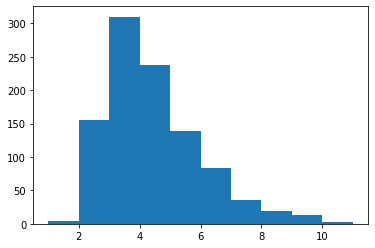

In [ ]:
# Plotting the distribution of streaks 
plt.hist(list_longest_streaks)
plt.show()

In [ ]:
srs_results_df

,total_matches_predicted,unavailable_srs_matches,predicted_matches_percentage,correct_predictions,accuracy,brier_score,proba Rafael Nadal - Richard Gasquet,proba Richard Gasquet - Rafael Nadal
2002,161,3052,5 %,82,0.509,0.367,NaN,NaN
2003,705,2513,21 %,339,0.481,0.392,0.416724,0.583276
2004,2783,505,84 %,1419,0.51,0.281,0.852546,0.147454
2005,2946,318,90 %,1524,0.517,0.262,0.446210,0.553790
2006,2852,415,87 %,1441,0.505,0.274,0.322682,0.677318
2007,2861,331,89 %,1442,0.504,0.269,0.487301,0.512699
2008,2831,292,90 %,1483,0.524,0.272,0.507719,0.492281
2009,2799,286,90 %,1492,0.533,0.271,0.432208,0.567792
2010,2665,365,87 %,1359,0.51,0.273,0.077665,0.922335
2011,2774,241,92 %,1441,0.519,NaN,0.298817,0.701183


In [ ]:
SWP_2009 = import_SWP_year(2009)
swp_2009, server_ratings_2009, receiver_ratings_2009 = preprocess_swp_df(SWP_2009)

In [ ]:
swp_2009

0.6519460634142453

In [ ]:
server_ratings_2009.loc[['Rafael Nadal', 'Richard Gasquet']]

,Rating
server,
Rafael Nadal,0.015408
Richard Gasquet,0.033405


In [ ]:
receiver_ratings_2009.loc[['Rafael Nadal', 'Richard Gasquet']]

,Rating
receiver,
Rafael Nadal,0.04422
Richard Gasquet,0.039831


In [ ]:
ranking_sheet_2009 = pd.read_excel('fitted_srs_regressed/atp_srs_rating_2009_fitted.xlsx',
                                  sheet_name = 'SRS',
                                  usecols='X:AC',
                                  skiprows=14
                                  ).iloc[4:,:]
ranking_sheet_2009.dropna().set_index('SRS (469,6)').loc[['Rafael Nadal', 'Richard Gasquet']]

,RMSE,0.12177335847029101,Unnamed: 26,Unnamed: 27,Unnamed: 28
"SRS (469,6)",,,,,
Rafael Nadal,0.015408,82,Rafael Nadal,0.04422,82
Richard Gasquet,0.033405,38,Richard Gasquet,0.039831,38


In [ ]:
SWP_2019 = import_SWP_year(2019)
swp_2019, server_ratings_2019, receiver_ratings_2019 = preprocess_swp_df(SWP_2019)

In [ ]:
swp_2019

0.6559620133782568

In [ ]:
server_ratings_2019.sort_values(by = 'Rating', ascending = False).head(5)

,Rating
server,
Thanasi Kokkinakis,0.305588
Maximilian Marterer,0.127052
Feliciano Lopez,0.105087
Juan Martin del Potro,0.104993
Jiri Vesely,0.09795


In [ ]:
receiver_ratings_2019.sort_values(by = 'Rating', ascending = False).head(5)

,Rating
receiver,
Thanasi Kokkinakis,0.305759
Juan Martin del Potro,0.12002
Maximilian Marterer,0.118386
Rafael Nadal,0.104095
Feliciano Lopez,0.103584


In [ ]:
ranking_sheet_2019 = pd.read_excel('fitted_srs_regressed/atp_srs_rating_2019_fitted.xlsx',
                                  sheet_name = 'SRS',
                                  usecols='X:AC',
                                  skiprows=14
                                  ).iloc[4:,:]
ranking_sheet_2019.dropna().set_index('SRS (368,6)').loc[['Thanasi Kokkinakis']]

,RMSE,0.14760348550108898,Unnamed: 26,Unnamed: 27,Unnamed: 28
"SRS (368,6)",,,,,
Thanasi Kokkinakis,0.305588,6,Thanasi Kokkinakis,0.305759,6
